In [1]:
#!pip install pycuda

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Cuda Map and Reduce Codes

In [3]:
%%writefile kmeans_map_reduce_steps.cu

#include <cuda_runtime.h>
#include <stdio.h>
#include <stdlib.h>
#include <math.h>


extern "C" __global__ void kmeans_map_step(float * data_mtx, int dim_x, int dim_y, \
                                          float * centers_mtx, int n_clusters, \
                                          float * output_mtx, float * output_labels)
{
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    //printf("Hello world from tid %d, thread %d, in block %d!\n", tid, threadIdx.x, blockIdx.x);
	  __syncthreads();

    //assign this thread tid to the ith column of the data_mtx
    // for all columns of the data mtx do this:
    if ( tid < dim_x ) //we don't care about threads with larger tid
    {   
        int col = tid;
        float current_best_val=-100.0 ;
          
        for (int k = 0; k< n_clusters; k++)
        { 
          float sq_dist_k=0 ;
          for (int row = 0; row< dim_y; row++)
          {
            float val_data_mtx = data_mtx[col+row*dim_x];
            float val_centers_mtx = centers_mtx[k+row*n_clusters];
            float diff = val_data_mtx-val_centers_mtx;
            sq_dist_k=sq_dist_k+diff*diff ;
          }
          
          output_mtx[col+k*dim_x]=sq_dist_k;   

          if (current_best_val< 0)
          {
            current_best_val=sq_dist_k;
            output_labels[tid] = k;
          }       
          else if (current_best_val>sq_dist_k)
          {
              output_labels[tid]=k;
              current_best_val=sq_dist_k;
          } 
        }           
    }
    
    return;
}

extern "C" __global__ void kmeans_reduce_step(float * data_mtx, float * est_labels_cxn,  int dim_x, \
                                              int dim_y, int n_clusters, int * output_counts, float * output_vectors) 
{
 int tid = blockIdx.x*blockDim.x + threadIdx.x;
 //printf("Hello world from tid %d, thread %d, in block %d!\n", tid, threadIdx.x, blockIdx.x);
 
 //assign this thread tid to the ith column of the data_mtx
 // each thread will print one element
 if ( tid < dim_x ) //we don't care about threads with larger tid
    {   
        printf("---------\n");  
        int col = tid;
        int val = (int) est_labels_cxn[col];
        printf("tid: %d, col: %d, est_labels_cxn[col]: %d\n", tid, col, val);

        // sets *add_out to 0.  Thread-safe.
        //atomicExch(add_out, 0);
        __syncthreads();
        
        // adds "1" to *add_out for each thread.
        atomicAdd(output_counts+val,1);

        for (int row = 0; row< dim_y; row++)
        {
          float item = data_mtx[col+row*dim_x];
          atomicAdd(output_vectors+val+row*n_clusters,item);
        }  
        __syncthreads();
                      
    }
}


Overwriting kmeans_map_reduce_steps.cu


In [4]:
!nvcc -ptx -o kmeans_map_reduce_steps.ptx kmeans_map_reduce_steps.cu

In [5]:
def plot_data(Xs_,C):
  Xs=Xs_[:1000] #to avoid plotting too many points
  fig = plt.figure()

  ax0 = fig.add_subplot(111)
  ax0.scatter([point[0] for point in Xs], [point[1] for point in Xs])
  ax0.set_title('Dataset')

  plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=300, c='r')

### Kmeans EM

In [6]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
from time import time
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

import numpy as np


In [7]:
n_samples=10000
n_features =2

n_clusters=np.int32(3)
dim_x= np.int32(n_samples)
dim_y=np.int32(n_features)


# Creating a n_features=2 Dim dataset with centers=3 clusters
np.random.seed(150)

Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters)

data_mtx=np.float32(Xs.T.copy())
#centers_mtx = data_mtx[:,:n_clusters]
centers_mtx = np.float32(np.random.randn(n_features,n_clusters))
C0=centers_mtx

print(f' data mtx shape: {data_mtx.shape}')
print(f' centers_mtx shape: {centers_mtx.shape}')


 data mtx shape: (2, 10000)
 centers_mtx shape: (2, 3)


In [8]:
print(C0)

[[ 0.42723256 -0.20620081 -0.68183655]
 [-0.83009964 -0.5555047  -1.9925631 ]]


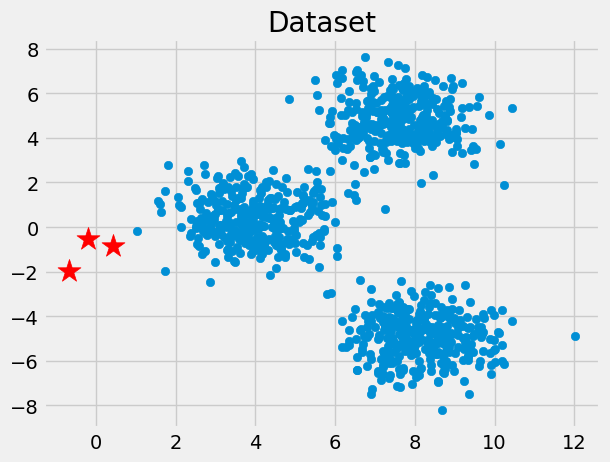

In [9]:
plot_data(Xs,centers_mtx.T)

In [10]:
output_mtx=np.float32(np.zeros([n_clusters,n_samples]))

data_gpu=gpuarray.to_gpu(data_mtx)
centers_mtx_gpu=gpuarray.to_gpu(centers_mtx)
output_mtx_gpu = gpuarray.to_gpu(output_mtx)



In [11]:
my_mod = pycuda.driver.module_from_file('./kmeans_map_reduce_steps.ptx')
kmeans_map_step_ker = my_mod.get_function('kmeans_map_step')
kmeans_reduce_step_ker = my_mod.get_function('kmeans_reduce_step')


In [12]:
blocksize = 100
gridsize = int(np.ceil(dim_x*dim_y / blocksize))

print(f'block size: {blocksize}')
print(f'grid size: {gridsize}')


block size: 100
grid size: 200


In [13]:
EM_iternum=10
for iters in np.arange(EM_iternum):

  output_labels=np.float32(-np.ones(n_samples))
  output_labels_gpu= gpuarray.to_gpu(output_labels)

  output_counts = np.int32(np.zeros(n_clusters))
  output_counts_gpu = gpuarray.to_gpu(output_counts)

  output_vectors = np.float32(np.zeros([dim_y, n_clusters]))
  output_vectors_gpu = gpuarray.to_gpu(output_vectors)

  print(f'iters:{iters}')
  #E-step
  kmeans_map_step_ker(data_gpu, np.int32(dim_x), np.int32(dim_y), centers_mtx_gpu, 
                      np.int32(n_clusters), output_mtx_gpu, output_labels_gpu, 
                      output_counts_gpu, grid=(gridsize, 1, 1), block=(blocksize,1,1))

  drv.Context.synchronize()
  est_labels_cxn_gpu=output_labels_gpu
  #print(est_labels_cxn_gpu.get().T)

  #M-step
  kmeans_reduce_step_ker(data_gpu, est_labels_cxn_gpu, dim_x, dim_y, n_clusters, output_counts_gpu, output_vectors_gpu, 
                        grid=(gridsize, 1, 1), block=(blocksize,1,1))

  drv.Context.synchronize()

  counts=output_counts_gpu.get()
  sum_vectors=output_vectors_gpu.get()

  #print(f'counts: {counts}' )
  #print(f'sum vectors:\n {sum_vectors}' )

  centers_mtx=np.float32(np.nan_to_num(sum_vectors/counts))
  centers_mtx_gpu=gpuarray.to_gpu(centers_mtx)
  #print(f'new centers:\n {centers_mtx_gpu}')

iters:0
iters:1
iters:2
iters:3
iters:4
iters:5
iters:6
iters:7
iters:8
iters:9


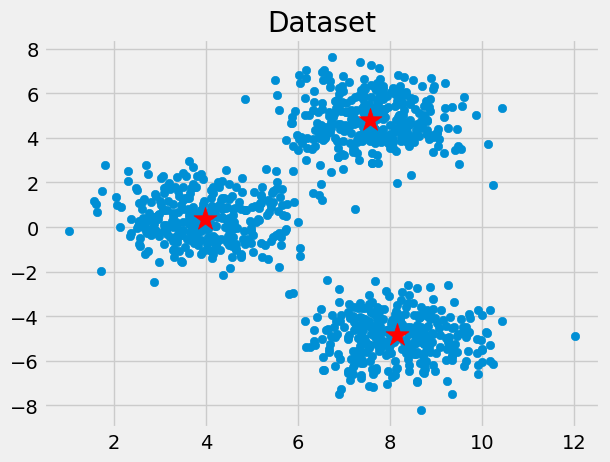

In [14]:
plot_data(Xs,centers_mtx.T)

In [15]:
centers_mtx

array([[ 7.5557847 ,  3.9681304 ,  8.151819  ],
       [ 4.7911477 ,  0.35051513, -4.8543077 ]], dtype=float32)

### Verification

In [16]:
C0

array([[ 0.42723256, -0.20620081, -0.68183655],
       [-0.83009964, -0.5555047 , -1.9925631 ]], dtype=float32)

In [17]:
if 0:

  print(f'--- GPU RESULTS ---')
  print(f'distances: \n {output_mtx_gpu.get().T[:10,:]}')
  print(f'counts: {counts}' )
  print(f'sum vectors:\n {sum_vectors}' )
  print(f'new centers:\n {centers_mtx_gpu}')
  print(f'labels:\n {est_labels_cxn_gpu.get()}')

  

  print(f'-----------------')

  centers_mtx = C0

  print('CPU verification:')
  output_mtx_cpu=np.float32(np.zeros([n_clusters,n_samples]))
  for i in np.arange(n_samples):
    for k in np.arange(n_clusters):
      val=data_mtx[:,i]-centers_mtx[:,k]
      output_mtx_cpu[k,i]=np.inner(val,val)
  print(output_mtx_cpu.T[:10,:])

  labels=np.argmin(output_mtx_cpu,axis=0)
  print(labels)
  tmp1=data_mtx.T
  tmp1

  tmp2=labels.T
  tmp2

  sum_vecs=[]
  counts=np.zeros(n_clusters)
  for iter in np.arange(n_clusters):
    inds = (tmp2==iter)
    inds
    counts[iter]=np.sum(inds)
    sum_vecs.append(np.sum(tmp1[inds,:],axis=0))
  
  print(counts)
  print(np.array(sum_vecs).T)
  C_new=np.array(sum_vecs).T/counts
  print(f'C_new:\n {C_new}')

  

In [18]:
if 0:
  plot_data(Xs,C_new.T)